# **ASkDAgger**: Active Skill-level Data Aggregation for Interactive Imitation Learning

This tutorial is a code example for the paper *ASkDAgger: Active Skill-level Data Aggregation for Interactive Imitation Learning*.
This code example will show how we can train a robot novice to perform a pick-and-place task using ASkDAgger.

### Overview of ASkDAgger

<img src=../figures/askdagger_overview.png width="50%">

**Figure 1**: The Active Skill-level Data Aggregation (ASkDAgger) framework consists of three main components: S-Aware Gating (SAG), Foresight Interactive Experience Replay (FIER), and Prioritized Interactive Experience Replay (PIER).
In this interactive imitation learning framework, we allow the novice to say: "*I plan to do this, but I am uncertain.*"
The uncertainty gating threshold is set by SAG to track a user-specified metric: sensitivity, specificity, or minimum system success rate.
Teacher feedback is obtained with FIER, enabling demonstrations through validation, relabeling, or teacher demonstrations.
Lastly, PIER prioritizes replay based on novice success, uncertainty, and demonstration age.

In [1]:
import askdagger_cliport
from askdagger_cliport.utils import utils
from askdagger_cliport.interactive_agent import InteractiveAgent
from askdagger_cliport import tasks
from askdagger_cliport.environments.environment import Environment
from askdagger_cliport.train_interactive import collect_demo

import os
import warnings
from hydra.experimental import compose, initialize
from pathlib import Path
from copy import deepcopy
from matplotlib import pyplot as plt
import shutil
import torch


gpu = "[0]"
if not torch.cuda.is_available():
  gpu = 0
  warnings.warn("Not using GPU runtime! Training on CPU is very slow.")

task_name = "put-block-in-bowl-seen-colors"
uncertainty_measure = "entropy"
validation_demos = "True"
FIER = "True"
PIER = "True"
n_demonstrations = 10
relabeling_demos = FIER
pier = PIER

root_dir = Path(askdagger_cliport.__file__).resolve().parents[1]
if os.path.exists(root_dir / "exps_notebook"):
    shutil.rmtree(root_dir / "exps_notebook")

with initialize(config_path="../src/askdagger_cliport/cfg"):
    icfg = compose(
        config_name="train_interactive",
        overrides=[
            # f"root_dir={root_dir}/demo",
            "train_interactive.log=False",
            f"train_interactive.pier={pier}",
            f"train_interactive.measure={uncertainty_measure}",
            f"train_interactive.gpu={gpu}",
            "train_interactive.batch_size=1",
            f"validation_demos={validation_demos}",
            f"relabeling_demos={relabeling_demos}",
            "train_demos=0",
            f"interactive_demos={n_demonstrations}",
            "save_model=True",
            "save_results=True",
            f"model_task={task_name}",
            f"train_interactive_task={task_name}",
            "disp=False",
            "exp_folder=exps_notebook",
        ],
    )

# Initialize environment and agent
env = Environment(icfg["assets_root"], disp=False, shared_memory=False, hz=480)
task = tasks.names[task_name]()
env.set_task(task)
interactive_agent = InteractiveAgent(icfg, mode="train")
seed = interactive_agent.seed

pybullet build time: Jan 29 2025 23:16:28
/home/jelle/askdagger_cliport/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jelle/askdagger_cliport/.venv/lib/python3.10/site-packages/wandb/sdk/internal/sender.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Save path for results: /home/jelle/askdagger_cliport/exps_notebook/put-block-in-bowl-seen-colors-cliport-n0-train/0/interactive_training/fier_True_pier_True_sensitivity_0.9
Loading from scratch.
Start interactive training. Seed: -2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Train novice interactively using ASkDAgger

Now we are ready to train! The training procedure is summarized below in Algorithm 1.
At the beginning of each episode, we reset the environment.
At each step of the episode, the novice receives a language command (which is printed) and observes the environment in the form of RGB-D data.
The novice infers its policy and we visualize the planned novice actions.
The novice quantifies the related uncertainty.
This uncertainty is used to perform gating between the novice and the teacher.
SAG sets the gating threshold to track a desired sensitivity level, in this case, 0.9.
If the uncertainty exceeds a threshold set SAG or in case of a random query with probability $p_\mathrm{rand}=0.2$, the teacher is queried.
We print the uncertainty level, current threshold, and whether the teacher is queried.
If queried, the teacher can relabel goal for the novice's planned actions if they are valid for some other language command.
Also, if the novice's plan is valid, the teacher can validate it and it will be aggregated into the dataset.
Demonstrations are also visualized if given.
Finally, we visualize the environment after an action is executed.
At the end of each episode, we aggregate the demonstrations into the dataset and update the model.

<img src='../figures/alg.png' width="75%">



-------------------------------------------------
Interactive demos: 0/10 | Seed: 0
Lang Goal: put the cyan blocks in a yellow bowl
Uncertainty: 1.000000 | Threshold: 1.000000


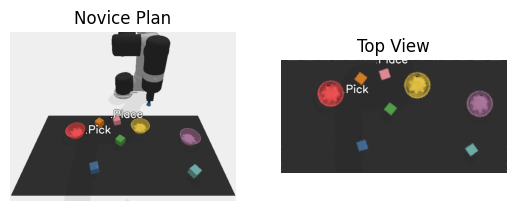

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


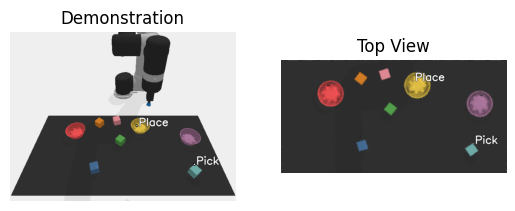

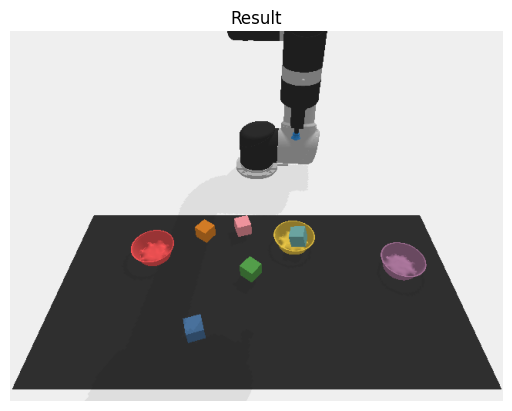


-------------------------------------------------
Interactive demos: 1/10 | Seed: 2
Lang Goal: put the cyan blocks in a blue bowl
Uncertainty: 0.999968 | Threshold: 0.999968


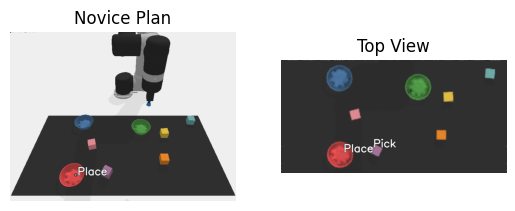

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


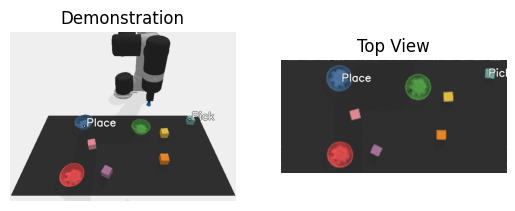

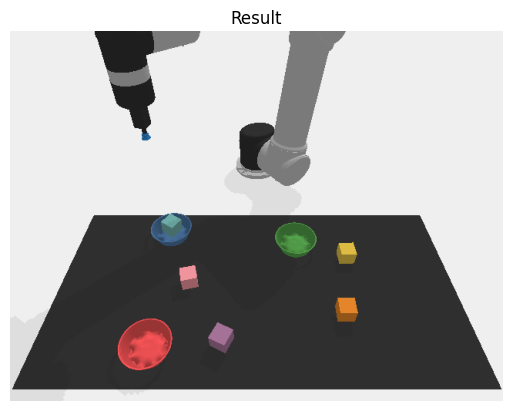


-------------------------------------------------
Interactive demos: 2/10 | Seed: 4
Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.998660 | Threshold: 0.998660


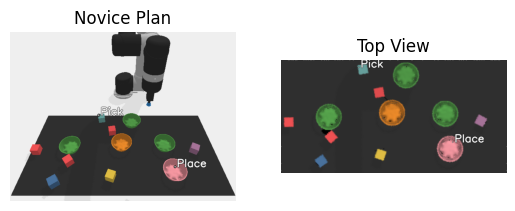

Relabeling demo: put the cyan blocks in a pink bowl
Annotation demo.
Query: True
Reward system: 0.333 | Reward novice: 0.000
Total reward system: 0.3333333333333333 | Total reward novice: 0


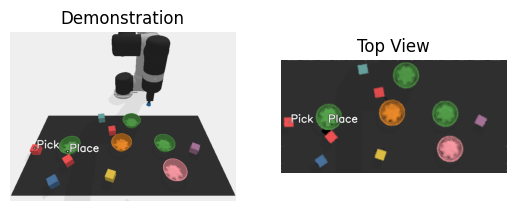

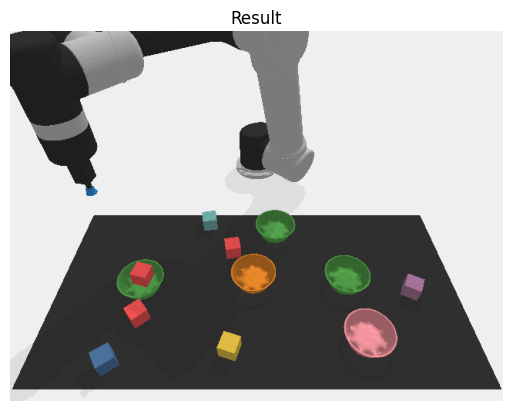

Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.998569 | Threshold: 0.998569


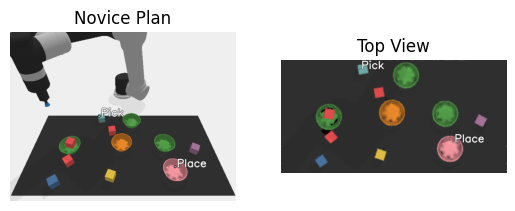

Relabeling demo: put the cyan blocks in a pink bowl
Annotation demo.
Query: True
Reward system: 0.333 | Reward novice: 0.000
Total reward system: 0.6666666666666666 | Total reward novice: 0.0


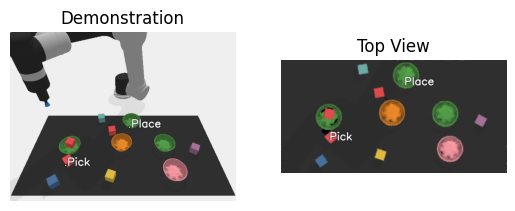

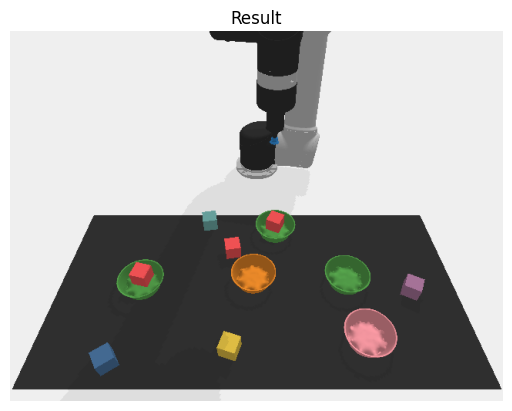

Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.998480 | Threshold: 0.998480


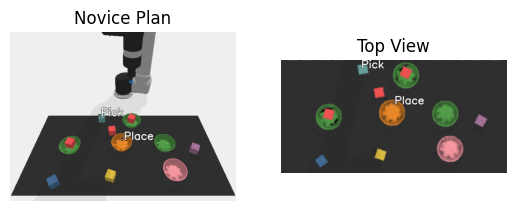

Relabeling demo: put the cyan blocks in a orange bowl
Annotation demo.
Query: True
Reward system: 0.333 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


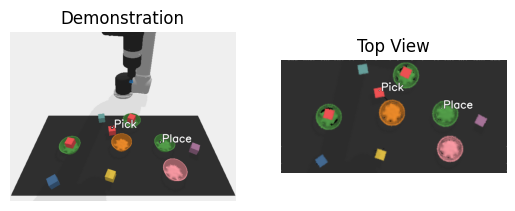

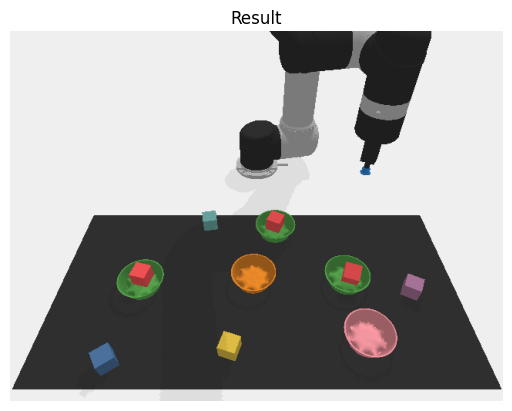


-------------------------------------------------
Interactive demos: 3/10 | Seed: 6
Lang Goal: put the cyan blocks in a brown bowl
Uncertainty: 0.993445 | Threshold: 0.993445


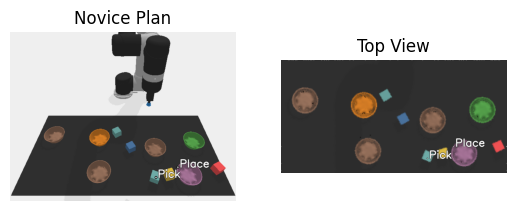

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


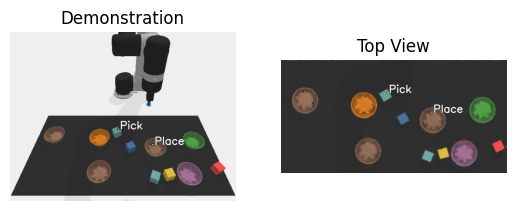

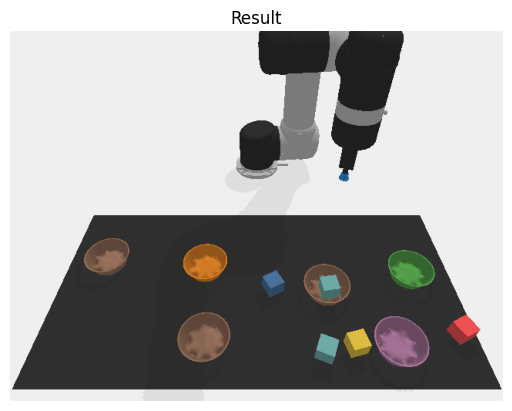

Lang Goal: put the cyan blocks in a brown bowl
Uncertainty: 0.993388 | Threshold: 0.993388


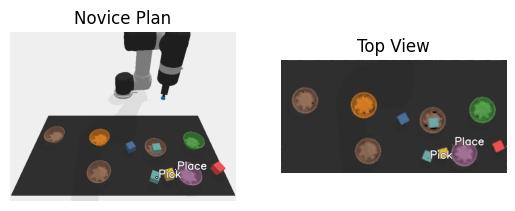

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


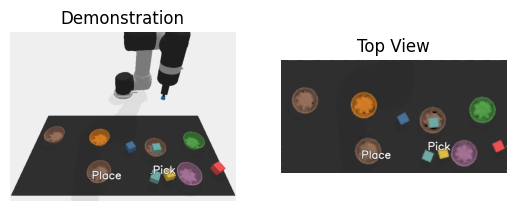

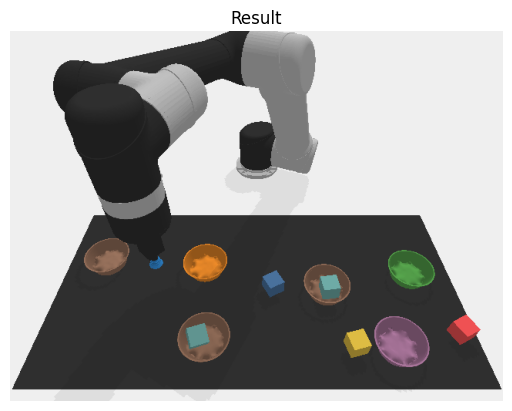


-------------------------------------------------
Interactive demos: 4/10 | Seed: 8
Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.977308 | Threshold: 0.977308


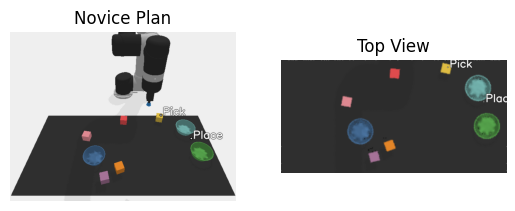

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


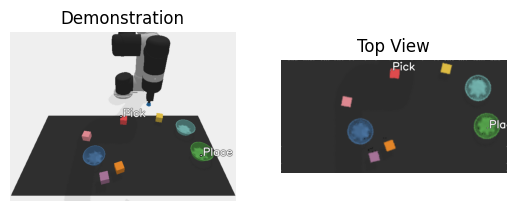

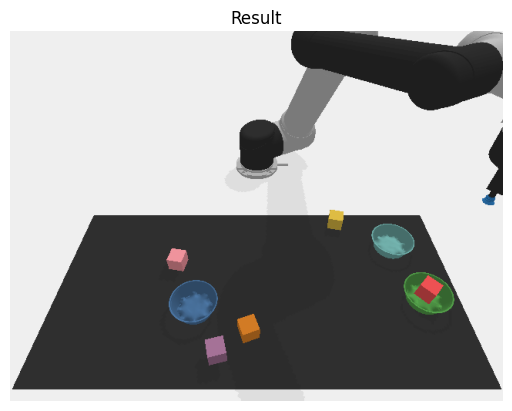


-------------------------------------------------
Interactive demos: 5/10 | Seed: 10
Lang Goal: put the brown blocks in a blue bowl
Uncertainty: 0.940863 | Threshold: 0.940863


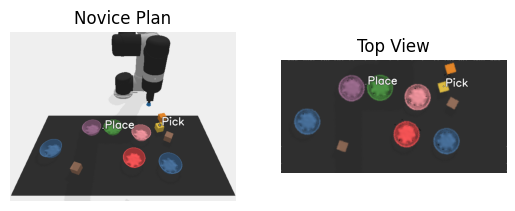

Relabeling demo: put the yellow blocks in a green bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


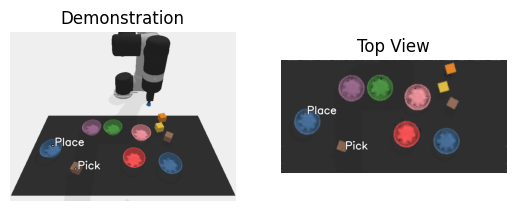

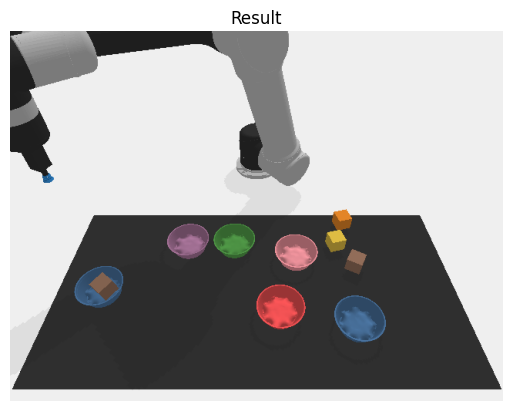

Lang Goal: put the brown blocks in a blue bowl
Uncertainty: 0.939244 | Threshold: 0.939244


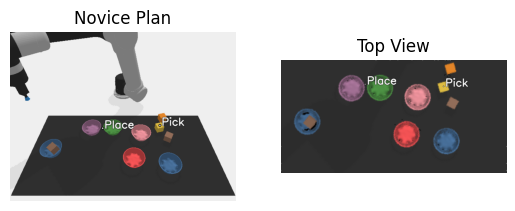

Relabeling demo: put the yellow blocks in a green bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


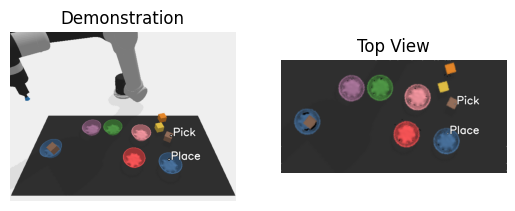

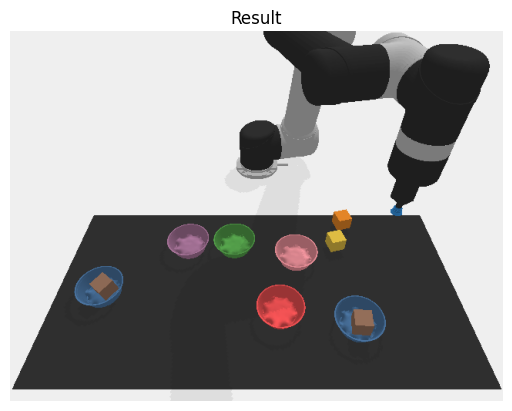


-------------------------------------------------
Interactive demos: 6/10 | Seed: 12
Lang Goal: put the yellow blocks in a green bowl
Uncertainty: 0.948694 | Threshold: 0.939244


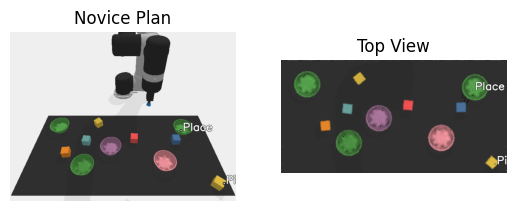

Validation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.500
Total reward system: 0.5 | Total reward novice: 0.5


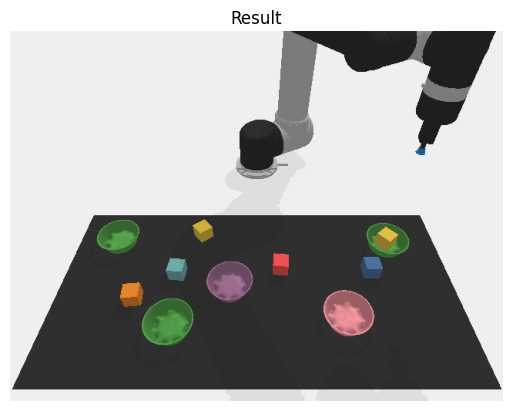

Lang Goal: put the yellow blocks in a green bowl
Uncertainty: 0.951336 | Threshold: 0.939244


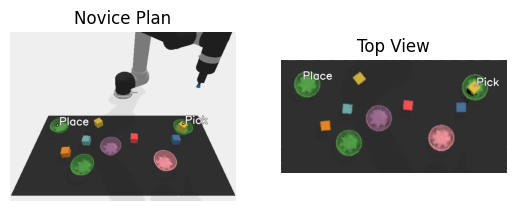

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.5
Mean system: 1.000 | Mean agent: 0.071


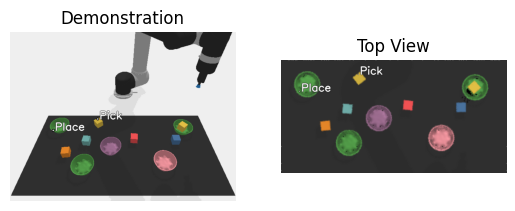

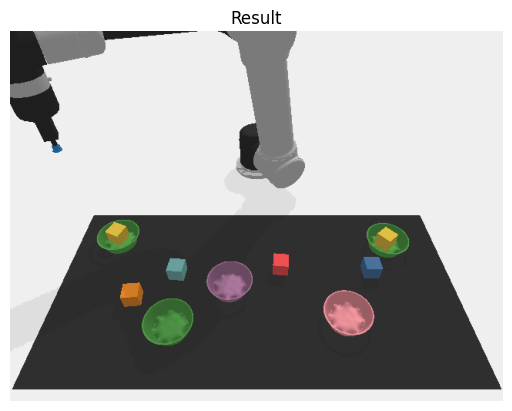


-------------------------------------------------
Interactive demos: 7/10 | Seed: 14
Lang Goal: put the blue blocks in a brown bowl
Uncertainty: 0.926592 | Threshold: 0.926592


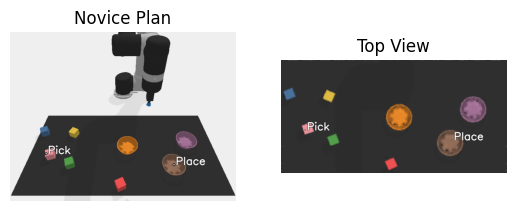

Relabeling demo: put the pink blocks in a brown bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.062


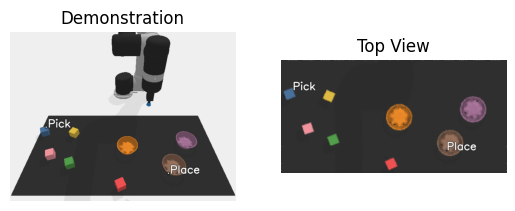

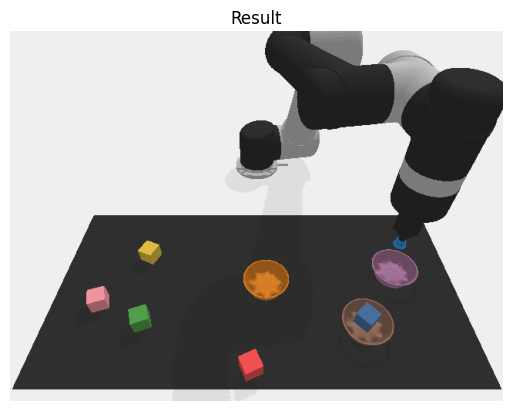


-------------------------------------------------
Interactive demos: 8/10 | Seed: 16
Lang Goal: put the green blocks in a yellow bowl
Uncertainty: 0.755567 | Threshold: 0.755567


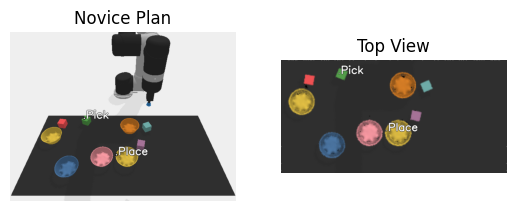

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.056


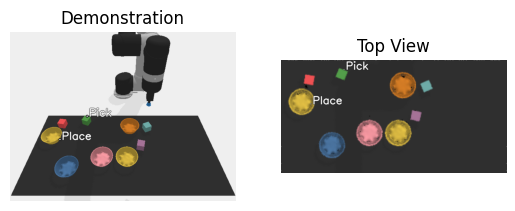

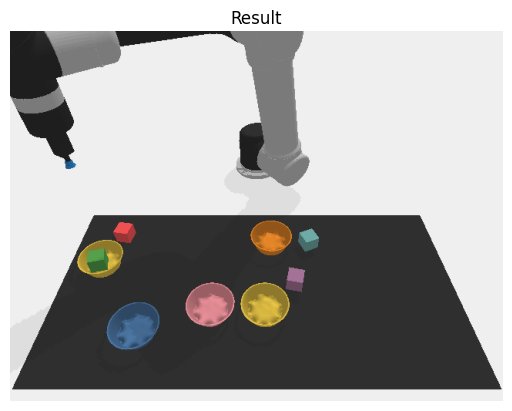


-------------------------------------------------
Interactive demos: 9/10 | Seed: 18
Lang Goal: put the red blocks in a blue bowl
Uncertainty: 0.670030 | Threshold: 0.670030


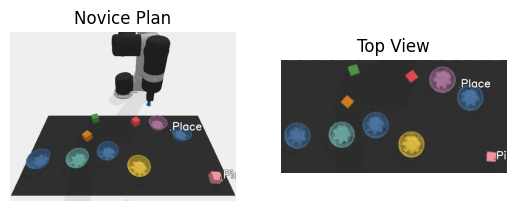

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.050


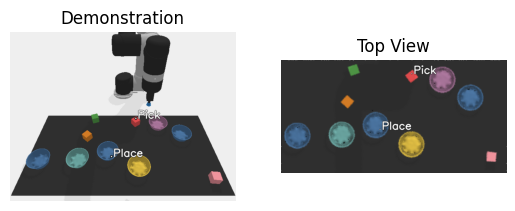

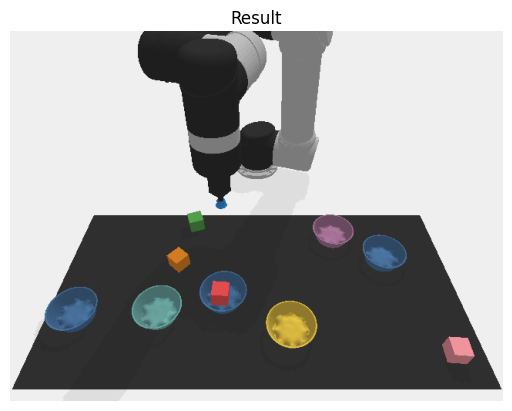

In [ ]:
while interactive_agent.n_interactive < n_demonstrations:
    seed += 2
    interactive_agent.seed = seed

    # Set seeds.
    utils.set_seed(seed)
    print("\n-------------------------------------------------\nInteractive demos: {}/{} | Seed: {}".format(interactive_agent.n_interactive, icfg["interactive_demos"], seed))

    task.mode = "train"
    obs, info = env.reset(seed=seed)
    D_i = []
    reward = 0
    for _ in range(task.max_steps):
        lang_goal = info["lang_goal"]
        print(f"Lang Goal: {lang_goal}")

        # Get agent action.
        if len(obs["color"]) == 0:
            obs = env.get_obs()  # Only rendering when the agent acts, since rendering is slow.
        agent_act, query = interactive_agent.act(obs, info)

        # Visualize the novice's planned action
        obs_copy = deepcopy(obs)
        info_copy = deepcopy(info)
        img, projected_img = interactive_agent.visualize_action(agent_act, obs_copy, info_copy)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img)
        ax[0].axis("off")
        ax[0].set_title("Novice Plan")
        ax[1].imshow(projected_img)
        ax[1].axis("off")
        ax[1].set_title("Top View")
        plt.show()

        # Query oracle if uncertainty is high.
        env, obs, reward, terminated, truncated, info, demo = collect_demo(
            obs=obs,
            reward=reward,
            info=info,
            env=env,
            agent_act=agent_act,
            query=query,
            interactive_agent=interactive_agent,
            relabeling_demos=relabeling_demos,
            validation_demos=validation_demos,
            p_rand=icfg["train_interactive"]["p_rand"],
        )
        done = terminated or truncated
        interactive_agent.update_stats(demo)

        # Rewards are privileged information, so we update it separately.
        # We only use this information for logging purposes
        interactive_agent.update_rewards(done, novice_reward=demo["novice_reward"], system_reward=reward)

        if demo["demo"] is not None:
            D_i.append(demo["demo"])
            if demo["oracle_demo"]:
                act = demo["demo"][1]

                # Visualize demonstration
                img, projected_img = interactive_agent.visualize_action(act, obs_copy, info_copy)
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(img)
                ax[0].axis("off")
                ax[0].set_title("Demonstration")
                ax[1].imshow(projected_img)
                ax[1].axis("off")
                ax[1].set_title("Top View")
                plt.show()

        if demo["relabeling_demo"] is not None:
            D_i.append(demo["relabeling_demo"])

        # Visualize environment after taking the action
        plt.title("Result")
        plt.imshow(env.render())
        plt.axis("off")
        plt.show()

        if done:
            break

    if len(D_i) > 0:
        if len(obs["color"]) == 0:
            obs = interactive_agent.get_image(env.get_obs())
        D_i.append((obs, None, reward, info))
        interactive_agent.add_demo(seed, D_i)
        interactive_agent.prioritize_replay()
    interactive_agent.update_model()